In [49]:
import math as ma
import yfinance as yf
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential, Model
from keras.initializers import glorot_uniform
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation, Input, concatenate
import datetime as dt
import matplotlib.pyplot as plt 
import pandas_ta as ta
import tensorflow as tf

from keras import optimizers
from keras.callbacks import History

np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


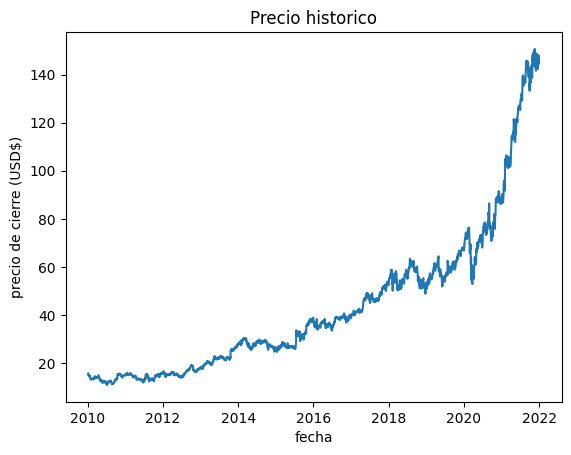

[[105.8395004 33.9532338 114.3856372 130.5019996 130.5019996]
 [108.2959976 38.2499181 113.8056715 130.0622768 130.0622768]
 [112.7990036 45.2458904 113.7097984 129.7204298 129.7204298]
 ...
 [133.9199982 46.8020858 135.8048477 131.2814026 131.2814026]
 [133.3200073 45.5693434 135.5681962 131.3217710 131.3217710]
 [130.6300049 40.4512275 135.0978923 131.3080726 131.3080726]]
(384, 5)


In [50]:
#var de testeo
stride = 50
simbolo = "Goog"
#conseguir la data
dfTrain = yf.download(tickers= simbolo, start= dt.datetime(2010,1,1), end= dt.datetime(2022,1,1))
dfTest =  yf.download(simbolo, start = dt.datetime(2022,1,1),end = dt.date.today()) #dt.date.today())

dataTrain = dfTrain.filter(['Close'])
grafData = dataTrain.copy()

#agrego indicadores: 
dataTrain['RSI']=ta.rsi(dataTrain['Close'], length=15)
dataTrain['EMAF']=ta.ema(dataTrain['Close'], length=20)
dataTrain['EMAM']=ta.ema(dataTrain['Close'], length=100)
dataTrain['EMAS']=ta.ema(dataTrain['Close'], length=150)
dataTrain.dropna(inplace=True)
#dataTrain.reset_index(inplace = True)
#agrego indicadores para test: 
dataTest = dfTest.filter(['Close'])

dataTest['RSI']=ta.rsi(dataTest['Close'], length=15)
dataTest['EMAF']=ta.ema(dataTest['Close'], length=20)
dataTest['EMAM']=ta.ema(dataTest['Close'], length=100)
lenEMAS = 150
dataTest['EMAS']=ta.ema(dataTest['Close'], length=lenEMAS-stride)

dataTestAux = dataTest['Close'][:lenEMAS-1]
dataTest.dropna(inplace=True)




plt.title('Precio historico')
plt.plot(grafData)
plt.xlabel("fecha")
plt.ylabel("precio de cierre (USD$)")
# plt.axis((2020,2023,ma.floor(min(dataTrain.values)), ma.ceil(max(dataTrain.values))))
plt.show()


# print((dataTrain['Close'][0] - min(dataTrain['Close']))/(max(dataTrain['Close'])-min(dataTrain['Close'])))
# print(dataTrain)

dataTrain =dataTrain.values 
dataTest = dataTest.values

# print(dfTrain)
# print(dfTest)
print(dataTest)
print((dataTest.shape))


In [51]:
#normalizar la data 
scaler = MinMaxScaler(feature_range=(0,1))
dataNormTrain = scaler.fit_transform(dataTrain)
dataNormTest = scaler.fit_transform(dataTest)

In [52]:
#crear el dataset de entrenamiento 
#separar entre X e Y dataSets
#X son las entradas e Y es la salida esperada
x_train = []
y_train = []


for i in range(stride, len(dataNormTrain)):
    x_train.append(dataNormTrain[i-stride:i, :])
    y_train.append(dataNormTrain[i,0])
    # if i<=stride:
    #     print(x_train)
    #     print(y_train)

#print(x_train[3], y_train[:3])

# for i in range(len(x_train)):
#     print(x_train[i], y_train[i]) 

#yi = np.array(dataNormTrain[stride:,-1])
#y=np.reshape(yi,(len(yi),1))

# for i in range(stride,len(dataNormTrain)):
#     x_train.append(dataNormTrain[i-stride:i,0])
#     y_train.append(dataNormTrain[i,0])




In [53]:
#hacerlos np.arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
#el modelo necesita el numero de samples, de datos y de features

In [54]:
#construir la red LSTM 
model = Sequential() 

model.add(LSTM(128, return_sequences= True, input_shape = (stride, x_train.shape[2])))
model.add(Dropout(0.2))
# model.add(LSTM(250, return_sequences= True))
# model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences= False))
model.add(Dropout(0.2))
#inputs = LSTM(100, name='first_layer')(lstm_input)

model.add(Dense(1, activation= 'linear'))
model.compile(optimizer=optimizers.Adam(), loss='mse')
model.fit(x=x_train, y=y_train, epochs=70, batch_size=32, shuffle=True, validation_split = 0.1) 

Epoch 1/70
80/80 [==============================] - 9s 72ms/step - loss: 0.0018 - val_loss: 0.0060
Epoch 2/70
80/80 [==============================] - 5s 62ms/step - loss: 3.6131e-04 - val_loss: 0.0043
Epoch 3/70
80/80 [==============================] - 5s 62ms/step - loss: 3.5632e-04 - val_loss: 5.9537e-04
Epoch 4/70
80/80 [==============================] - 5s 61ms/step - loss: 3.1942e-04 - val_loss: 0.0030
Epoch 5/70
80/80 [==============================] - 5s 62ms/step - loss: 2.8321e-04 - val_loss: 0.0020
Epoch 6/70
80/80 [==============================] - 5s 62ms/step - loss: 2.6323e-04 - val_loss: 4.0800e-04
Epoch 7/70
80/80 [==============================] - 5s 61ms/step - loss: 2.7849e-04 - val_loss: 3.4776e-04
Epoch 8/70
80/80 [==============================] - 5s 62ms/step - loss: 3.2706e-04 - val_loss: 0.0042
Epoch 9/70
80/80 [==============================] - 5s 61ms/step - loss: 2.4405e-04 - val_loss: 3.7863e-04
Epoch 10/70
80/80 [==============================] - 5s 65ms/

In [55]:
#crea datos para test
#separa en X y en Y 

# testData = np.concatenate((dataTestAuxNorm[-stride:,:],dataNormTest)) 
testData = dataNormTest
# print(testData[:30,:])
x_test = []
y_test = dataTest[stride:,0]

# print(len(dataTest))

for i in range(stride, len(testData)):
     x_test.append(testData[i-stride:i,:])
#X contiene los valores no contempleados en el train, e y contiene la salida esperada
x_test = np.array(x_test)

#x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],x_test.shape[2]))
#print(x_test[1])
#print(y_test[1])


In [56]:
#prediccion del modelo para test

prediccion = np.zeros((x_test.shape[0],x_test.shape[2]))
aux = model.predict(x_test)
print(aux.shape)
aux = np.reshape(aux,(aux.shape[0]))
#print(aux)

prediccion[:,0] = aux[:]
prediccion = scaler.inverse_transform(prediccion)
prediccion = prediccion[:,0]
# print(prediccion.shape[0])

11/11 [==============================] - 1s 22ms/step
(334, 1)


In [57]:
#calcular error del modelo (RMSE)
rmse = np.sqrt(np.mean((prediccion - y_test)**2))
print('RMSE: ',"{:.2f}".format(rmse))


RMSE:  3.93


In [58]:
#Arma las estructuras para  graficar
train = dfTrain
valid = dfTest
prediccion = np.concatenate((dataTestAux[:], prediccion[:]))
print(prediccion.shape)

(483,)


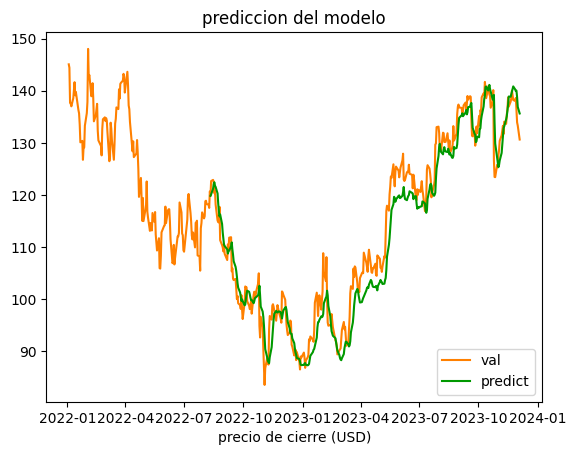

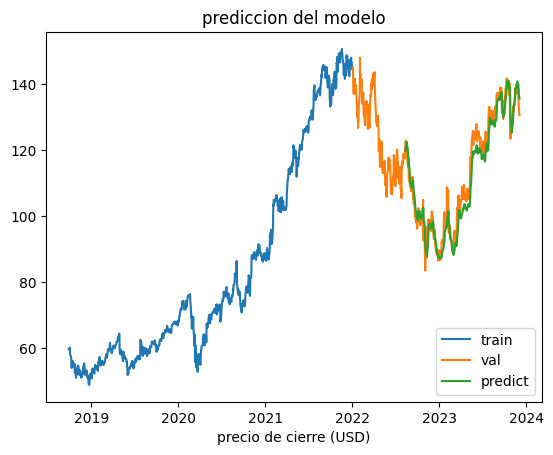

In [59]:

#testData = np.concatenate((dataNormTrain[-stride:,:],dataNormTest)) 

valid['Predictions'] = prediccion


#plot
plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("precio de cierre (USD)")
#plt.plot(train['Close'][2000:])
plt.plot(valid['Close'], color = (1.0, 0.5, 0.0)) 
plt.plot(valid['Predictions'][152:], color =  (0.0, 0.6, 0.0))
plt.legend(['val', 'predict'], loc = 'lower right')
plt.figure()


plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("precio de cierre (USD)")
plt.plot(train['Close'][2200:])
plt.plot(valid['Close']) 
plt.plot(valid['Predictions'][152:])
plt.legend(['train', 'val', 'predict'], loc = 'lower right')
plt.show()


In [60]:
valid = valid[153:]

C:\Users\nahue\AppData\Local\Temp\ipykernel_31200\1019828568.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  difPred = [valid['Predictions'][i+1] - valid['Predictions'][i] for i in range(valid.shape[0]-1)]
C:\Users\nahue\AppData\Local\Temp\ipykernel_31200\1019828568.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  difVal = [valid['Close'][i+1] - valid['Close'][i] for i in range(valid.shape[0]-1)]


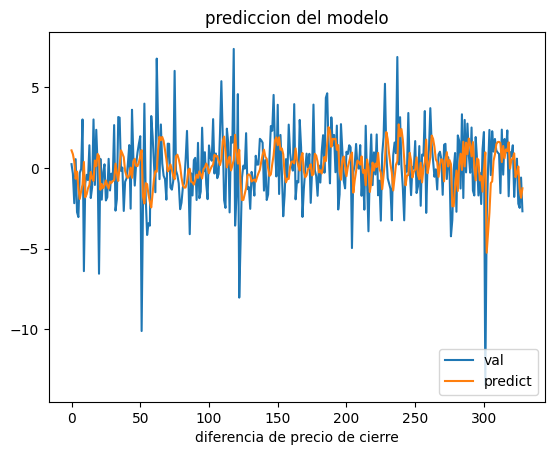

In [69]:
difPred = [valid['Predictions'][i+1] - valid['Predictions'][i] for i in range(valid.shape[0]-1)]
difVal = [valid['Close'][i+1] - valid['Close'][i] for i in range(valid.shape[0]-1)]
difPred = np.array(difPred)
difVal = np.array(difVal)


plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("diferencia de precio de cierre")
plt.plot(difVal)
plt.plot(difPred) 
plt.legend(['val', 'predict'], loc = 'lower right')
plt.show()

In [77]:
L = len(difPred)
mitad = ma.floor(L/2)
PM = difPred[:mitad]
SM = difPred[mitad:]
difPred = np.concatenate((difPred[:mitad], SM[ma.floor(mitad/2):], SM[:ma.floor(mitad/2)]))

In [79]:

combined_arrays = zip(difVal, difPred)
same_sign_count = sum(1 for a, b in combined_arrays if (a > 0 and b > 0) or (a < 0 and b < 0))
print('Promedio de diferencias:',(same_sign_count / difVal.shape[0])*100)

Promedio de diferencias: 54.1033434650456


In [63]:
#imprimir los valores
print(valid[['Close', 'Predictions']][149:])

                 Close  Predictions
Date                               
2023-03-17  102.459999    93.577181
2023-03-20  101.930000    95.463490
2023-03-21  105.839996    96.865219
2023-03-22  104.220001    98.756216
2023-03-23  106.260002    99.877484
...                ...          ...
2023-11-28  138.619995   139.937947
2023-11-29  136.399994   140.021206
2023-11-30  133.919998   138.756900
2023-12-01  133.320007   136.904397
2023-12-04  130.630005   135.636857

[181 rows x 2 columns]


In [67]:
#simulacion de trading 

#print(dataNormTest[:,0])
dataReal = valid['Predictions']
dataReal = np.array(dataReal)

dataTestSemana = dataReal[-5:]
dataTestMes = dataReal[-20:]
dataTestAnual = dataReal[-250:]

testCase = dataTestAnual
#print(len(dataTestSemana))
# print(dataTestMes)
# print(dataTestAnual)

#difPred
difPredS = difPred[-len(testCase):]
dineroHist = []

#simulacion:
dineroInicial = 1000

cantAcciones =ma.floor(dineroInicial/testCase[0])
dinero = dineroInicial - cantAcciones*testCase[0]
print(dinero)
for i in range(len(testCase)):
    print()
    print('precio diario: ',testCase[i])
    print('diferencia: ', difPredS[i])
    
    if (difPredS[i] > 0): #si mañana va a subir, compro y holdeo
        while (dinero >= testCase[i]):
            cantAcciones += 1
            dinero -= testCase[i]
        dinero += 5
    else: #va a bajar, conviene vender
        dinero += cantAcciones*testCase[i]
        cantAcciones = 0
    print('dinero:', dinero)
    print('cant acciones:', cantAcciones)
    dineroHist.append(dinero + cantAcciones*testCase[i])

dinero += cantAcciones*testCase[i]
cantAcciones = 0

print()
print('Dinero inicial: $',dineroInicial)
print('Dinero final: $', dinero)
print('Rendimiento: ',(1- dineroInicial / dinero)*100 ,'%')
# print(testCase)
# print(predic)


15.400521481128635

precio diario:  98.45994785188714
diferencia:  0.12888125336121448
dinero: 20.400521481128635
cant acciones: 10

precio diario:  97.86440984097078
diferencia:  -0.595538010916357
dinero: 999.0446198908364
cant acciones: 0

precio diario:  96.78195008621356
diferencia:  -1.082459754757224
dinero: 999.0446198908364
cant acciones: 0

precio diario:  95.55658240800881
diferencia:  -1.2253676782047478
dinero: 999.0446198908364
cant acciones: 0

precio diario:  94.33891113965353
diferencia:  -1.217671268355275
dinero: 999.0446198908364
cant acciones: 0

precio diario:  93.45833707136705
diferencia:  -0.880574068286478
dinero: 999.0446198908364
cant acciones: 0

precio diario:  93.34305225938874
diferencia:  -0.11528481197831297
dinero: 999.0446198908364
cant acciones: 0

precio diario:  93.29257585024072
diferencia:  -0.05047640914801832
dinero: 999.0446198908364
cant acciones: 0

precio diario:  92.43127446655308
diferencia:  -0.8613013836876462
dinero: 999.0446198908364

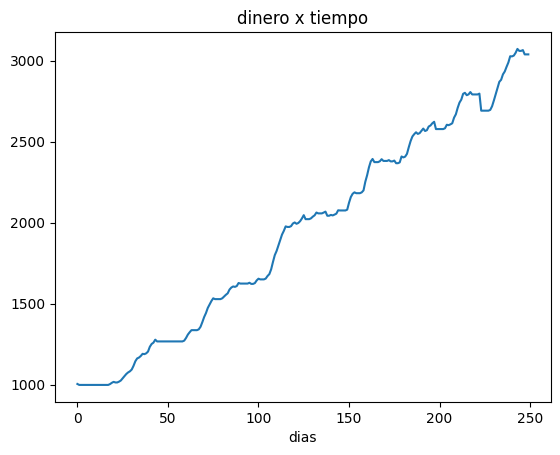

In [68]:
#print(dineroHist)

plt.title("dinero x tiempo")
plt.xlabel("dinero")
plt.xlabel("dias")
plt.plot(dineroHist) 
plt.show()

